In [1]:
import nibabel as nb
import os
import glob
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import numpy as np

In [18]:
feature_description = {
    'patient':tf.io.FixedLenFeature([], tf.string),
    'image_type':tf.io.FixedLenFeature([], tf.string),
    'is_mask':tf.io.FixedLenFeature([], tf.int64),
    'image_tensor':tf.io.FixedLenFeature([], tf.string),
}
file_name = 'ACV_ADC_AND_MASKS.tfrecords'

def create_example_from_nii(patient, image_type, is_mask, image_tensor):
    feature={
        'patient'     :tf.train.Feature(bytes_list=tf.train.BytesList(value=[patient])),
        'image_type'  :tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_type])),
        'is_mask'     :tf.train.Feature(int64_list=tf.train.Int64List(value=[is_mask])),
        'image_tensor':tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image_tensor).numpy()]))
        }
    
    example=tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()
    

def make_dataset(
    search_pattern,
    keywords,
    source_dir,
    dest_dir,
    dataset_name,
    exceptions=None,
    include_masks=False,
    verbose=False):
    """
    Fetches nii.gz files with an additional pattern provided
    and load the images as nibabel objects to serialize them 
    and save them into a tfrecord file.
    """
    MASK_PATH_KEYWORD = 'MASKS'
    DISCRIMINATORS = keywords
    dataset_file_name = f'{dataset_name}.tfrecords'
    
    # Relocates the file pointer for the search
    os.chdir(source_dir)
    
    if verbose:
        print(f'Searching on root: {source_dir}')
        
    # Find the files for the files
    paths = []
    for key in keywords:
        pattern = search_pattern(key)
        paths += glob.glob(os.path.join(source_dir, pattern), recursive=True)
    
    if verbose:
        print(f'{len(paths)} files found')
        print('Converting images to nibabel objects, encoding and saving...')
    
    os.chdir(dest_dir)
    count = 0
    mask_count = 0
    excluded = 0
    info_except = 0
    paths_omitted = []
    paths_included = []
    
    if verbose:
        print('[', end='')
        
    # Loads the files as nibabel objects and save the bytes version into the tfrecord    
    with tf.io.TFRecordWriter(dataset_file_name) as writer:
        for idx, path in enumerate(paths):
            
            # if there is more than 1 then concatenates with an OR
            if len(DISCRIMINATORS) > 1:
                concat_string = '|'
            else:
                concat_string = ''
                
            # Finds the image labels
            is_omitted=False
            paciente = re.search('ACV-...', path.upper())
            tipo_imagen = re.search(concat_string.join(DISCRIMINATORS).upper(), path.upper())
            
            # Checks for an actual match, otherwise continues with the next iteration
            if paciente is None:
                info_except += 1
                paths_omitted.append(path)
                continue
            if tipo_imagen is None:
                info_except += 1
                paths_omitted.append(path)
                continue
            
            # Gets the strings of the match
            paciente = paciente.group()
            tipo_imagen = tipo_imagen.group()
            
            # Checks if the path match any exception pattern
            if exceptions is not None:
                if not is_omitted:
                    if len(exceptions) > 1:
                        exception = re.search('|'.join(exceptions).upper(), path.upper())
                    else:
                        exception = re.search(''.join(exceptions).upper(), path.upper())
                    
                    if exception is not None:
                        is_omitted = True
            
            if is_omitted:
                excluded += 1
                paths_omitted.append(path)
                continue
            
            if include_masks:
                mask_match = re.search(MASK_PATH_KEYWORD, path.upper())
            else:
                mask_match = None
            
            if mask_match is None:
                is_mask = False
            else:
                is_mask = True
            
            # Loads the file
            image_tensor = nb.load(path).get_fdata()
            if not is_mask:
                count+=1
            elif include_masks:
                mask_count+=1
            else:
                continue
                
            # Convert the image into tf.train.example
            example = create_example_from_nii(
                paciente.encode('utf-8'),
                tipo_imagen.encode('utf-8'),
                is_mask,
                image_tensor)
            
            paths_included.append(path)
            
            # Saves the file
            writer.write(example)
            
            if verbose and idx%int(len(paths)/100) == 0:
                print('|', end='')
    print(']')
    
    if verbose:
        print(f'{count + mask_count} images saved (including masks)')
        print(f'{mask_count} Masks saved')
        print(f'{excluded} files omitted by exception pattern match')
        print(f'{info_except} files omitted by information required mismatch')
        print(f'Dataset saved at {dataset_file_name}')
        
    # Saves the paths either included or omitted to files
    with open('paths_excluded.txt', 'w') as file:
        file.write('\n'.join(paths_omitted))
    
    with open('paths_included.txt', 'w') as file:
        file.write('\n'.join(paths_included))
        
    print('Paths either included or omitted are saved at files: \n- paths_excluded.txt\n- paths_included.txt')


search_pattern = lambda s: os.path.join('**', f'{s}.nii.gz')
make_dataset(
    search_pattern,
    ['ADC', 'DWI'],
    '/data/Datasets/stroke/ISBI_FOSCAL/',
    '/home/srazul/Tesis/',
    'ACV_DWI-ADC_W_MASKS',
    exceptions=['registered', 'optiBET'],
    include_masks=True,
    verbose=True
    ) 


Searching on root: /data/Datasets/stroke/ISBI_FOSCAL/
422 files found
Converting images to nibabel objects, encoding and saving...
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||]
420 images saved (including masks)
267 Masks saved
2 files omitted by exception pattern match
0 files omitted by information required mismatch
Dataset saved at ACV_DWI-ADC_W_MASKS.tfrecords
Paths either included or omitted are saved at files: 
- paths_excluded.txt
- paths_included.txt


fase 1
fase 2
fase 3


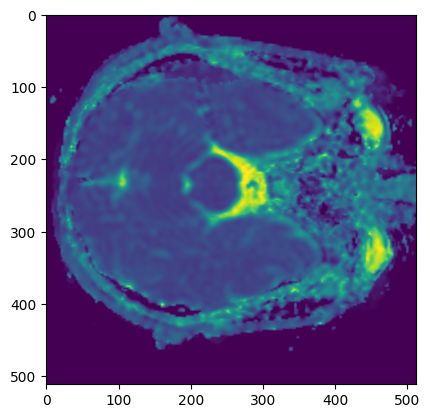

In [4]:
raw_data = tf.data.TFRecordDataset('test_1.tfrecord')

def parse_example(proto):
    #return tf.train.Example.FromString(proto)
    return tf.io.parse_single_example(proto, feature_description)
    
dataset = raw_data.map(parse_example)

for feat in dataset:
    img = tf.io.parse_tensor(feat['image_tensor'], out_type=tf.double).numpy()

print('fase 3')
plt.imshow(img[:, :, 10])
plt.show()

In [ ]:
sample_image = nib_files[0].get_fdata()
plt.imshow(sample_image[:, :, 10])
plt.show()
print(sample_image.shape)

In [ ]:

reshaped = sample_image.flatten()
reshaped.shape

In [ ]:
reconstructed = reshaped.reshape(sample_image.shape)
plt.imshow(reconstructed[:, :, 10])
plt.show()
reconstructed.shape

In [ ]:
serialized = tf.io.serialize_tensor(sample_image)
tensor = tf.io.parse_tensor(serialized, tf.dtypes.double)
print(tensor.shape)
plt.imshow(tensor[:, :, 10])
plt.show()

In [ ]:
feat = tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized.numpy()]))

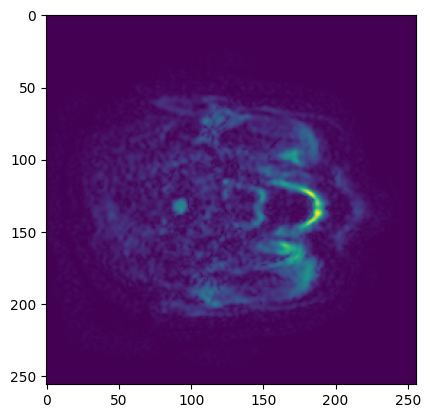

In [9]:
img = nb.load('/data/Datasets/stroke/ISBI_FOSCAL/ACV-208/2022-08-25-DWI/DWI.nii.gz').get_fdata()
plt.imshow(img[:, :, 1, 0])
plt.show()

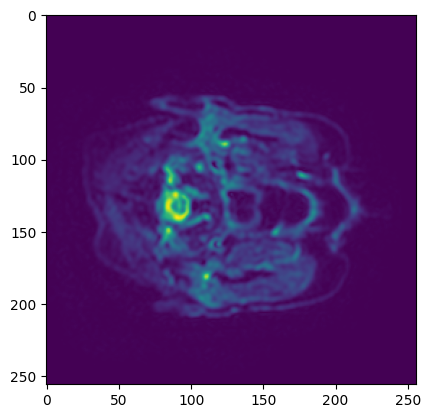

In [10]:
plt.imshow(img[:, :, 1, 1])
plt.show()

(256, 256, 24)


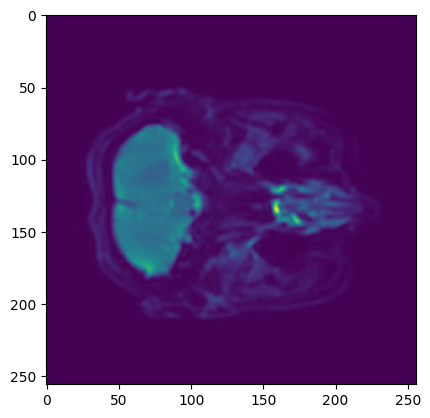

In [14]:
added = img.sum(axis=3)
print(added.shape)
plt.imshow(added[:, :, 5])
plt.show()

In [6]:
img = nb.load('/data/Datasets/stroke/ISBI_FOSCAL/ACV-208/Masks/Daniel//DWI.nii.gz').get_fdata()
img.shape

(256, 256, 24)

#  